In [105]:
#Note: In this notebook we calculate all metrics for ONE model. Still, in many places
#in code variables names contain `ensemble` word. Please, ignore it.

COLAB_MODELS_ID = '1XwRhDEtUjy27SdKHMk7ytt7VCw0dOvHO'
PATH_METRICS = 'metrics_ensemble'
MODEL_NAME_FORMAT = lambda i: f'model_{i}.pt'
ARCHIVE_NAME = 'one_model.zip'

PATH_CIFAR10_MODELS = 'one_model/cifar10/'
ENSEMBLE_SIZE_CIFAR10 = 1

PATH_CIFAR100_MODELS = 'one_model/cifar100/'
ENSEMBLE_SIZE_CIFAR100 = 1

In [106]:
!mkdir $PATH_METRICS 
!mkdir plots
!mkdir utils 

mkdir: cannot create directory ‘metrics_ensemble’: File exists
mkdir: cannot create directory ‘plots’: File exists
mkdir: cannot create directory ‘utils’: File exists


## 1. Load data

In [112]:
%%capture
!pip install gdown

In [113]:
%%capture
!gdown --id $COLAB_MODELS_ID
!unzip $ARCHIVE_NAME
!rm $ARCHIVE_NAME

## 2. Import dependencies

In [144]:
import os
from tqdm import tqdm
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.model
%aimport utils.attacks
%aimport utils.uncertainty_baselines
%aimport utils.adversarial_radius

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3. Prepare dataloaders

In [115]:
_, (train_loader_10, test_loader_10) = utils.data.get_train_test_dataloaders(
            dataset_type='cifar10',
            root_data_folder='./data',
            batch_size=64
            )

Files already downloaded and verified
Files already downloaded and verified


In [116]:
_, (train_loader_100, test_loader_100) = utils.data.get_train_test_dataloaders(
            dataset_type='cifar100',
            root_data_folder='./data',
            batch_size=64
            )

Files already downloaded and verified
Files already downloaded and verified


## 4. Tests
### 4.1 CIFAR10

#### Load models of ensemble

In [117]:
PATH_METRICS_CIFAR10 = PATH_METRICS + '/cifar10'
!mkdir $PATH_METRICS_CIFAR10

mkdir: cannot create directory ‘metrics_ensemble/cifar10’: File exists


In [146]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#base model
model_10 = torchvision.models.resnet50(pretrained=False)
model_10.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
model_10 = model_10.to(device)

In [147]:
#get models of ensemble
model_list_10 = []
for i in range(ENSEMBLE_SIZE_CIFAR10):
    model = copy.deepcopy(model_10)
    model.load_state_dict(torch.load(PATH_CIFAR10_MODELS + MODEL_NAME_FORMAT(i), map_location=device))
    model_list_10.append(model)

#### Get baseline metrics

In [120]:
utils.uncertainty_baselines.uncertainty_estimation(
    model=model_list_10[0],
    loader=test_loader_10,
    device=device,
    save=True,
    path2save=PATH_METRICS_CIFAR10+'/uncertainty_baselines.npz',
)

100%|██████████| 157/157 [00:07<00:00, 21.15it/s]


#### Get adversarial radii metrics

In [173]:
#mean radii, l2 norm

utils.adversarial_radius.get_adversarial_radii_on_ensemble(
    model_list=model_list_10,
    loader=test_loader_10,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    max_steps=100,
    tol=1e-5,
    step_size=0.8,
    device=device,
    norm='l2',
    save=True,
    path2save=PATH_METRICS_CIFAR10+'/adversarial_radii_mean_l2.npz'
)

100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


In [148]:
#mean radii, inf norm

utils.adversarial_radius.get_adversarial_radii_on_ensemble(
    model_list=model_list_10,
    loader=test_loader_10,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    max_steps=200,
    tol=1e-5,
    step_size=0.05,
    device=device,
    norm='inf',
    save=True,
    path2save=PATH_METRICS_CIFAR10+'/adversarial_radii_mean_inf.npz'
)

100%|██████████| 157/157 [06:51<00:00,  2.62s/it]


In [123]:
#step radii, l2 norm

utils.adversarial_radius.get_step_radii_on_ensemble(
    model_list=model_list_10,
    loader=test_loader_10,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    eps=0.01,
    max_steps=100,
    device=device,
    norm='l2',
    save=True,
    path2save=PATH_METRICS_CIFAR10+'/step_radii_mean_l2.npz'
)

100%|██████████| 157/157 [08:45<00:00,  3.35s/it]


In [124]:
#step radii, inf norm

utils.adversarial_radius.get_step_radii_on_ensemble(
    model_list=model_list_10,
    loader=test_loader_10,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    eps=0.005,
    max_steps=1000,
    device=device,
    norm='inf',
    save=True,
    path2save=PATH_METRICS_CIFAR10+'/step_radii_mean_inf.npz'
)

100%|██████████| 157/157 [01:34<00:00,  1.66it/s]


In [125]:
#approximation of adversarial radii with norm * (top1_prob-top2_prob)
baselines = np.load(PATH_METRICS_CIFAR10+'/uncertainty_baselines.npz')

maxprob_adversarial_radii10 = utils.adversarial_radius.get_maxprob_adversarial_radii(
    p2_p1=baselines['margin'],
    model=model_list_10[0],
    loader=test_loader_10,
    loss=nn.CrossEntropyLoss(),
    device=device,
    norm=2,
    path2save=PATH_METRICS_CIFAR10+'/maxprob_adversarial_radii.npz'
)

100%|██████████| 157/157 [00:05<00:00, 29.48it/s]


#### Get rejection curves for baselines

In [174]:
baselines = np.load(PATH_METRICS_CIFAR10+'/uncertainty_baselines.npz')
rejection_rates = np.linspace(0, 1, 1000)
rejection_curves_ensemble_cifar10 = {}
metrics_10 = {}

#Calculate values of accuracy for each rejection rate based on baseline uncertainty metrics
for uncertainty_proxy in ['entropy',
                          'std',
                          'maxprobs',
                          'margin']:
    rejection_curves_ensemble_cifar10[uncertainty_proxy] = utils.uncertainty_baselines.reject_by_metric(
        uncertainty_proxy=baselines[uncertainty_proxy],
        preds=baselines['preds'],
        labels=baselines['targets'],
        rejection_rates=rejection_rates,
        scoring_func=accuracy_score)
    metrics_10[' '.join(uncertainty_proxy.split('_'))] = baselines[uncertainty_proxy]
    
#Calculate values of absolute confidence curve
rejection_curves_ensemble_cifar10['absolute confidence'] = utils.uncertainty_baselines.get_best_vals_for_plot(
    baselines['preds'], 
    baselines['targets'],
    rejection_rates[:-1])

#Calculate values of accuracy for each rejection rate based on random uncertainty metrics
np.random.seed(40)
random_proxy = np.random.uniform(size=len(baselines['targets']))
rejection_curves_ensemble_cifar10['random uncertainty'] = utils.uncertainty_baselines.reject_by_metric(
    uncertainty_proxy=random_proxy,
    preds=baselines['preds'],
    labels=baselines['targets'],
    rejection_rates=rejection_rates,
    scoring_func=accuracy_score)

#### Get rejection curves for adversarial radii and step radii

In [175]:
rejection_rates = np.linspace(0, 1, 1000)
rejection_curves_radii_ensemble_cifar10 = {}

#adversarial radii
adversarial_radii_mean_l2_cifar10_ensemble = np.load(PATH_METRICS_CIFAR10+'/adversarial_radii_mean_l2.npz')
adversarial_radii_mean_inf_cifar10_ensemble = np.load(PATH_METRICS_CIFAR10+'/adversarial_radii_mean_inf.npz')
# maxprob_radii = np.load(PATH_METRICS_CIFAR10+'/maxprob_adversarial_radii.npz')
radii_metrics = [adversarial_radii_mean_l2_cifar10_ensemble,
                 adversarial_radii_mean_inf_cifar10_ensemble,
                #  maxprob_radii
                 ]

radii_metrics_names = ['adv.rad, l2-norm',
                       'adv.rad, inf-norm',
                      #  'maxprob adv.rad, l2-norm'
                       ]

for uncertainty_proxy, radii_metric in zip(radii_metrics_names, radii_metrics):
    rejection_curves_radii_ensemble_cifar10[uncertainty_proxy] = utils.uncertainty_baselines.reject_by_metric(
        uncertainty_proxy=-radii_metric['mean_adversarial_radii'],
        preds=baselines['preds'],
        labels=baselines['targets'],
        rejection_rates=rejection_rates,
        scoring_func=accuracy_score)
    metrics_10[uncertainty_proxy] = -radii_metric['mean_adversarial_radii']
    
#step radii
step_radii_mean_l2_cifar10_ensemble = np.load(PATH_METRICS_CIFAR10+'/step_radii_mean_l2.npz')
step_radii_mean_inf_cifar10_ensemble = np.load(PATH_METRICS_CIFAR10+'/step_radii_mean_inf.npz')

step_metrics = [step_radii_mean_l2_cifar10_ensemble, 
                step_radii_mean_inf_cifar10_ensemble]

step_metrics_names = ['step rad. l2-norm',
                      'step rad. inf-norm']

for uncertainty_proxy, step_metric in zip(step_metrics_names, step_metrics):
    rejection_curves_radii_ensemble_cifar10[uncertainty_proxy] = utils.uncertainty_baselines.reject_by_metric(
        uncertainty_proxy=-step_metric['mean_step_radii'],
        preds=baselines['preds'],
        labels=baselines['targets'],
        rejection_rates=rejection_rates,
        scoring_func=accuracy_score)
    metrics_10[uncertainty_proxy] = -step_metric['mean_step_radii']

In [128]:
del model_10
del model_list_10

### 4.2 CIFAR100

#### Load models of ensemble

In [129]:
PATH_METRICS_CIFAR100 = PATH_METRICS + '/cifar100'
!mkdir $PATH_METRICS_CIFAR100

mkdir: cannot create directory ‘metrics_ensemble/cifar100’: File exists


In [150]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#base model
model_100 = torchvision.models.resnet50(pretrained=False)
model_100.fc = nn.Linear(in_features=2048, out_features=100, bias=True)
model_100 = model_100.to(device)

In [151]:
#get models of ensemble
model_list_100 = []
for i in range(ENSEMBLE_SIZE_CIFAR100):
    model = copy.deepcopy(model_100)
    model.load_state_dict(torch.load(PATH_CIFAR100_MODELS + MODEL_NAME_FORMAT(i), map_location=device))
    model_list_100.append(model)

#### Get baseline metrics

In [132]:
utils.uncertainty_baselines.uncertainty_estimation(
    model=model_list_100[0],
    loader=test_loader_100,
    save=True,
    path2save=PATH_METRICS_CIFAR100+'/uncertainty_baselines.npz',
    device=device
)

100%|██████████| 157/157 [00:03<00:00, 39.74it/s]


#### Get adversarial radii metrics

In [172]:
#mean radii, l2 norm

utils.adversarial_radius.get_adversarial_radii_on_ensemble(
    model_list=model_list_100,
    loader=test_loader_100,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    max_steps=100,
    tol=1e-5,
    step_size=0.8,
    device=device,
    norm='l2',
    save=True,
    path2save=PATH_METRICS_CIFAR100+'/adversarial_radii_mean_l2.npz'
)

100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


In [156]:
#mean radii, inf norm

utils.adversarial_radius.get_adversarial_radii_on_ensemble(
    model_list=model_list_100,
    loader=test_loader_100,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    max_steps=200,
    tol=1e-5,
    step_size=0.05,
    device=device,
    norm='inf',
    save=True,
    path2save=PATH_METRICS_CIFAR100+'/adversarial_radii_mean_inf.npz'
)

100%|██████████| 157/157 [07:04<00:00,  2.70s/it]


In [135]:
#step radii, l2 norm

utils.adversarial_radius.get_step_radii_on_ensemble(
    model_list=model_list_100,
    loader=test_loader_100,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    eps=0.01,
    max_steps=100,
    device=device,
    norm='l2',
    save=True,
    path2save=PATH_METRICS_CIFAR100+'/step_radii_mean_l2.npz'
)

100%|██████████| 157/157 [08:06<00:00,  3.10s/it]


In [136]:
#step radii, inf norm

utils.adversarial_radius.get_step_radii_on_ensemble(
    model_list=model_list_100,
    loader=test_loader_100,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    eps=0.005,
    max_steps=1000,
    device=device,
    norm='inf',
    save=True,
    path2save=PATH_METRICS_CIFAR100+'/step_radii_mean_inf.npz'
)

100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


In [137]:
#approximation of adversarial radii with norm * (top1_prob-top2_prob)
baselines = np.load(PATH_METRICS_CIFAR100+'/uncertainty_baselines.npz')

maxprob_adversarial_radii10 = utils.adversarial_radius.get_maxprob_adversarial_radii(
    p2_p1=baselines['margin'],
    model=model_list_100[0],
    loader=test_loader_100,
    loss=nn.CrossEntropyLoss(),
    device=device,
    norm=2,
    path2save=PATH_METRICS_CIFAR100+'/maxprob_adversarial_radii.npz'
)

100%|██████████| 157/157 [00:05<00:00, 29.78it/s]


#### Get rejection curves for baselines

In [176]:
baselines = np.load(PATH_METRICS_CIFAR100+'/uncertainty_baselines.npz')
rejection_rates = np.linspace(0, 1, 1000)
rejection_curves_ensemble_cifar100 = {}
metrics_100 = {}

#Calculate values of accuracy for each rejection rate based on baseline uncertainty metrics
for uncertainty_proxy in ['entropy',
                          'std',
                          'maxprobs',
                          'margin']:
    rejection_curves_ensemble_cifar100[uncertainty_proxy] = utils.uncertainty_baselines.reject_by_metric(
        uncertainty_proxy=baselines[uncertainty_proxy],
        preds=baselines['preds'],
        labels=baselines['targets'],
        rejection_rates=rejection_rates,
        scoring_func=accuracy_score)
    metrics_100[' '.join(uncertainty_proxy.split('_'))] = baselines[uncertainty_proxy]
    
#Calculate values of absolute confidence curve
rejection_curves_ensemble_cifar100['absolute confidence'] = utils.uncertainty_baselines.get_best_vals_for_plot(
    baselines['preds'], 
    baselines['targets'],
    rejection_rates[:-1])

#Calculate values of accuracy for each rejection rate based on random uncertainty metrics
np.random.seed(40)
random_proxy = np.random.uniform(size=len(baselines['targets']))
rejection_curves_ensemble_cifar100['random uncertainty'] = utils.uncertainty_baselines.reject_by_metric(
    uncertainty_proxy=random_proxy,
    preds=baselines['preds'],
    labels=baselines['targets'],
    rejection_rates=rejection_rates,
    scoring_func=accuracy_score)

#### Get rejection curves for adversarial radii and step radii

In [177]:
rejection_rates = np.linspace(0, 1, 1000)
rejection_curves_radii_ensemble_cifar100 = {}

#adversarial radii
adversarial_radii_mean_l2_cifar100_ensemble = np.load(PATH_METRICS_CIFAR100+'/adversarial_radii_mean_l2.npz')
adversarial_radii_mean_inf_cifar100_ensemble = np.load(PATH_METRICS_CIFAR100+'/adversarial_radii_mean_inf.npz')
# maxprob_radii = np.load(PATH_METRICS_CIFAR100+'/maxprob_adversarial_radii.npz')
radii_metrics = [adversarial_radii_mean_l2_cifar100_ensemble,
                 adversarial_radii_mean_inf_cifar100_ensemble,
                #  maxprob_radii
                 ]

radii_metrics_names = ['adv.rad, l2-norm',
                       'adv.rad, inf-norm',
                      #  'maxprob adv.rad, l2-norm'
                       ]

for uncertainty_proxy, radii_metric in zip(radii_metrics_names, radii_metrics):
    rejection_curves_radii_ensemble_cifar100[uncertainty_proxy] = utils.uncertainty_baselines.reject_by_metric(
        uncertainty_proxy=-radii_metric['mean_adversarial_radii'],
        preds=baselines['preds'],
        labels=baselines['targets'],
        rejection_rates=rejection_rates,
        scoring_func=accuracy_score)
    metrics_100[uncertainty_proxy] = -radii_metric['mean_adversarial_radii']
    
#step radii
step_radii_mean_l2_cifar100_ensemble = np.load(PATH_METRICS_CIFAR100+'/step_radii_mean_l2.npz')
step_radii_mean_inf_cifar100_ensemble = np.load(PATH_METRICS_CIFAR100+'/step_radii_mean_inf.npz')

step_metrics = [step_radii_mean_l2_cifar100_ensemble, 
                step_radii_mean_inf_cifar100_ensemble]

step_metrics_names = ['step rad. l2-norm',
                      'step rad. inf-norm']

for uncertainty_proxy, step_metric in zip(step_metrics_names, step_metrics):
    rejection_curves_radii_ensemble_cifar100[uncertainty_proxy] = utils.uncertainty_baselines.reject_by_metric(
        uncertainty_proxy=-step_metric['mean_step_radii'],
        preds=baselines['preds'],
        labels=baselines['targets'],
        rejection_rates=rejection_rates,
        scoring_func=accuracy_score)
    metrics_100[uncertainty_proxy] = -step_metric['mean_step_radii']

In [140]:
del model_100
del model_list_100

#### Visualize rejection curves

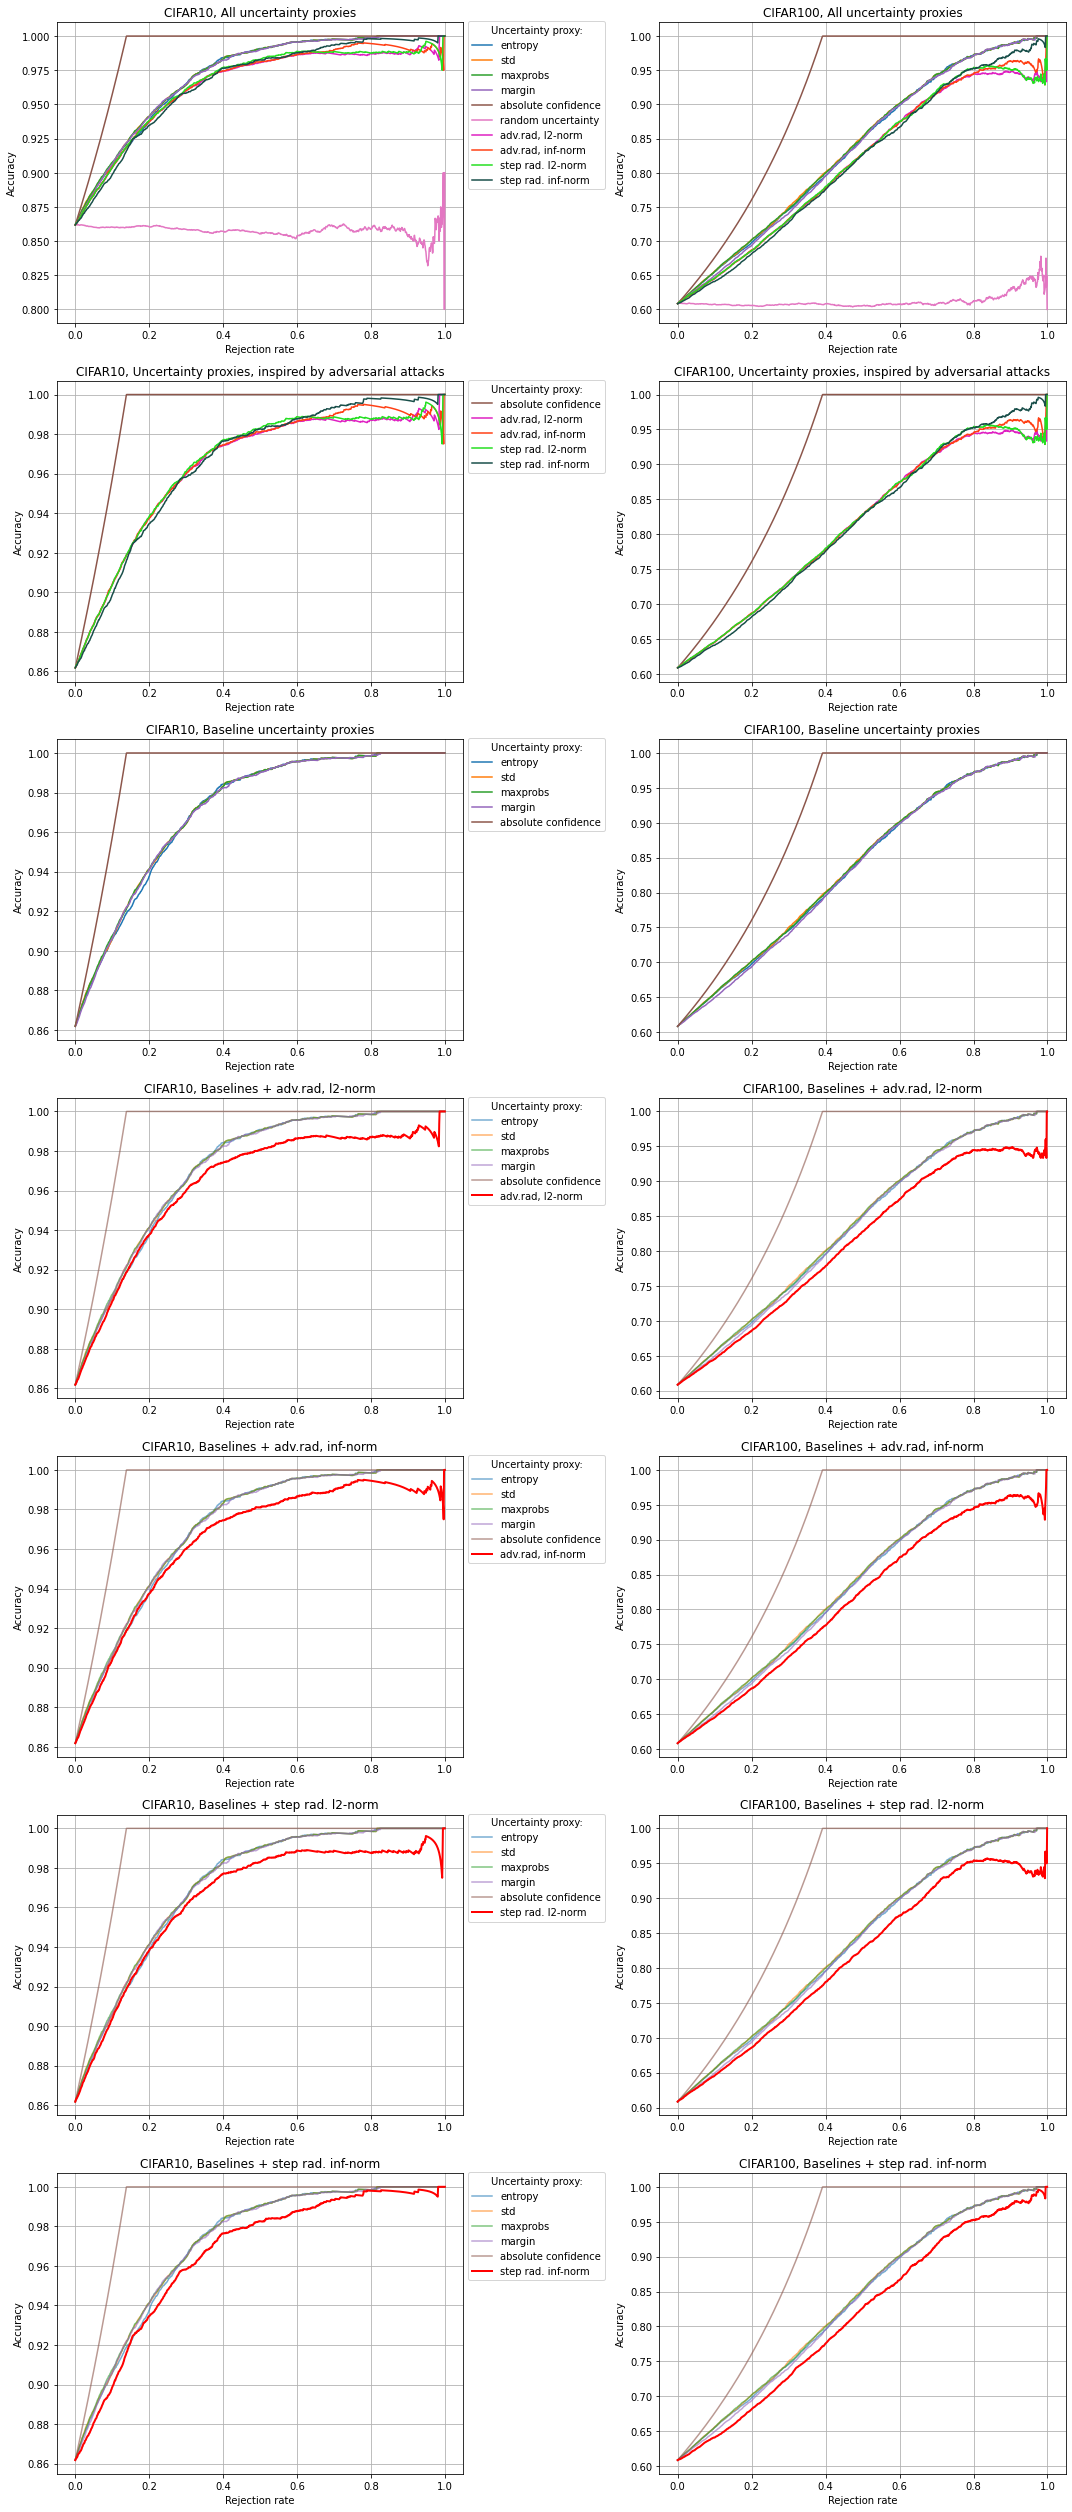

In [178]:
radii_proxy_names = list(rejection_curves_radii_ensemble_cifar10.keys())
colors = dict(zip(rejection_curves_ensemble_cifar10.keys(),
         ['tab:blue','tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan', 'tab:olive']))
colors_radii = dict(zip(rejection_curves_radii_ensemble_cifar10.keys(),
         ['#df20c2','#ff3f14', '#23df20', '#184e49', '#204ddf']))

titles = ['All uncertainty proxies', 'Uncertainty proxies, inspired by adversarial attacks',
         'Baseline uncertainty proxies', 'Baselines + adv.rad, l2-norm', 'Baselines + adv.rad, inf-norm',
         'Baselines + step rad. l2-norm', 'Baselines + step rad. inf-norm']
fig, ax = plt.subplots(7, 2, figsize=(15, 35))

#CIFAR10
for i in range(7):
    for uncertainty_proxy in rejection_curves_ensemble_cifar10.keys():
        label = ' '.join(uncertainty_proxy.split('_'))
        if i == 0:
            ax[i][0].plot(rejection_rates[:-1], rejection_curves_ensemble_cifar10[uncertainty_proxy],
                          label=label, c=colors[uncertainty_proxy])
        if (i > 1 and (uncertainty_proxy != 'random uncertainty')):
            ax[i][0].plot(rejection_rates[:-1], rejection_curves_ensemble_cifar10[uncertainty_proxy],
                              label=label, alpha=0.6 if i!=2 else 1, c=colors[uncertainty_proxy])
    if i == 1:
        ax[i][0].plot(rejection_rates[:-1], rejection_curves_ensemble_cifar10['absolute confidence'],
                      label='absolute confidence', c=colors['absolute confidence'])
    if i in (0, 1):
        for uncertainty_proxy in rejection_curves_radii_ensemble_cifar10.keys():
            ax[i][0].plot(rejection_rates[:-1], rejection_curves_radii_ensemble_cifar10[uncertainty_proxy],
                          label=' '.join(uncertainty_proxy.split('_')), c=colors_radii[uncertainty_proxy])
    elif i > 2:
        ax[i][0].plot(rejection_rates[:-1], rejection_curves_radii_ensemble_cifar10[radii_proxy_names[i-3]],
                      label=radii_proxy_names[i-3], color='red', lw=2.0)
    
    ax[i][0].set_title('CIFAR10, '+titles[i])
    ax[i][0].set_xlabel('Rejection rate')
    ax[i][0].set_ylabel('Accuracy')
    ax[i][0].grid(visible=True)
    ax[i][0].legend(title='Uncertainty proxy:', bbox_to_anchor=(1, 1.02))
    
#CIFAR100 
for i in range(7):
    for uncertainty_proxy in rejection_curves_ensemble_cifar100.keys():
        label = ' '.join(uncertainty_proxy.split('_'))
        if i == 0:
            ax[i][1].plot(rejection_rates[:-1], rejection_curves_ensemble_cifar100[uncertainty_proxy],
                          label=label, c=colors[uncertainty_proxy])
        if (i > 1 and (uncertainty_proxy != 'random uncertainty')):
            ax[i][1].plot(rejection_rates[:-1], rejection_curves_ensemble_cifar100[uncertainty_proxy],
                              label=label, alpha=0.6 if i!=2 else 1, c=colors[uncertainty_proxy])
    if i == 1:
        ax[i][1].plot(rejection_rates[:-1], rejection_curves_ensemble_cifar100['absolute confidence'],
                      label='absolute confidence', c=colors['absolute confidence'])
    if i in (0, 1):
        for uncertainty_proxy in rejection_curves_radii_ensemble_cifar100.keys():
            ax[i][1].plot(rejection_rates[:-1], rejection_curves_radii_ensemble_cifar100[uncertainty_proxy],
                          label=' '.join(uncertainty_proxy.split('_')), c=colors_radii[uncertainty_proxy])
    elif i > 2:
        ax[i][1].plot(rejection_rates[:-1], rejection_curves_radii_ensemble_cifar100[radii_proxy_names[i-3]],
                      label=radii_proxy_names[i-3], color='red', lw=2.0)
    
    ax[i][1].set_title('CIFAR100, '+titles[i])
    ax[i][1].set_xlabel('Rejection rate')
    ax[i][1].set_ylabel('Accuracy')
    ax[i][1].grid(visible=True)
#     ax[i][1].legend(title='Uncertainty proxy:')

plt.tight_layout()
fig.savefig('plots/rejection_curves.pdf', bbox_inches='tight')

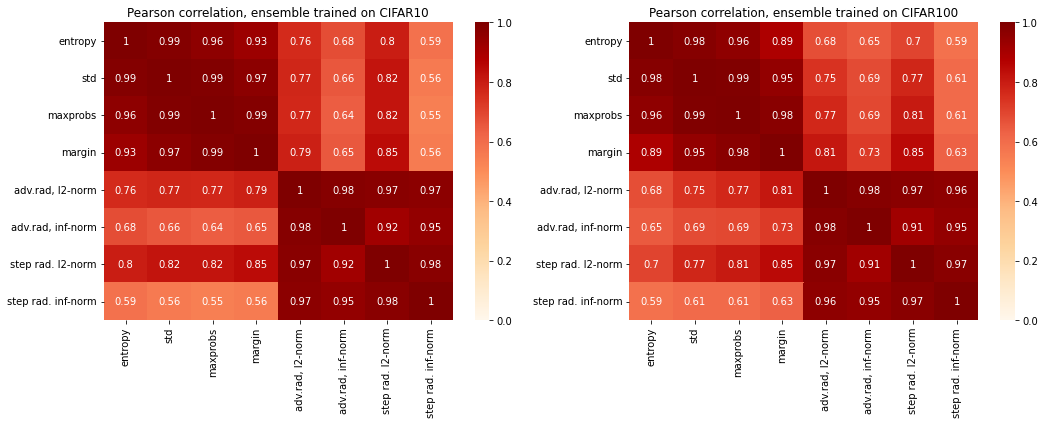

In [179]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(pd.DataFrame(metrics_10).corr(method='pearson'), annot=True, vmin=0, vmax=1, ax=ax[0], cmap='OrRd')
ax[0].set_title('Pearson correlation, ensemble trained on CIFAR10')
sns.heatmap(pd.DataFrame(metrics_100).corr(method='pearson'), annot=True, vmin=0, vmax=1, ax=ax[1], cmap='OrRd')
ax[1].set_title('Pearson correlation, ensemble trained on CIFAR100')
plt.tight_layout()
fig.savefig('plots/pearson_correlations.pdf', bbox_inches='tight')

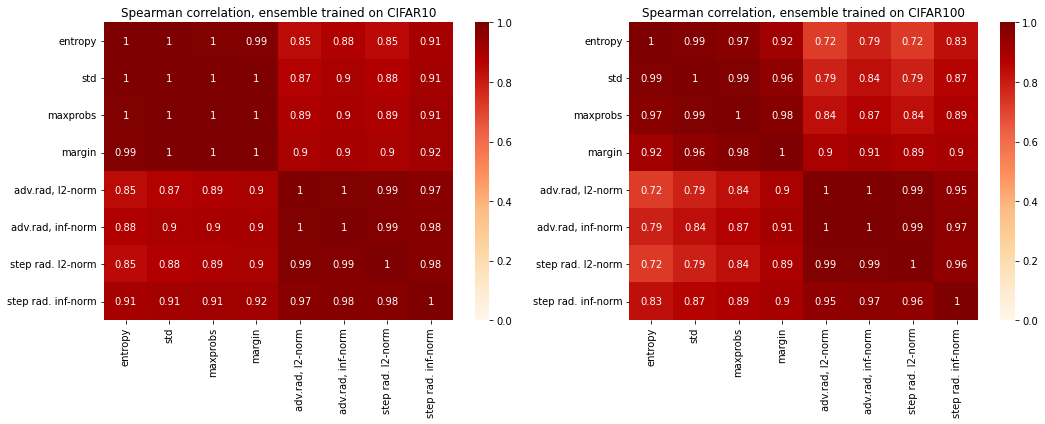

In [180]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(pd.DataFrame(metrics_10).corr(method='spearman'), annot=True, vmin=0, vmax=1, ax=ax[0], cmap='OrRd')
ax[0].set_title('Spearman correlation, ensemble trained on CIFAR10')
sns.heatmap(pd.DataFrame(metrics_100).corr(method='spearman'), annot=True, vmin=0, vmax=1, ax=ax[1], cmap='OrRd')
ax[1].set_title('Spearman correlation, ensemble trained on CIFAR100')
plt.tight_layout()
fig.savefig('plots/spearman_correlations.pdf', bbox_inches='tight')

In [181]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [182]:
# ! cp -r plots /content/drive/MyDrive/

In [183]:
# ! cp -r metrics_ensemble /content/drive/MyDrive/